# Data Pre-processing

Import Libraries

In [111]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns

#outlier detection
from scipy import stats

# feature scaling
from sklearn.preprocessing import StandardScaler
import numpy as np

Reading Dataset

In [2]:
raw_data_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
raw_data_df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
print("Number of rows %d"%raw_data_df.shape[0])
print("Number of columns %d"%raw_data_df.shape[1])

Number of rows 5110
Number of columns 12


Features' Datatypes

In [4]:
raw_data_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Data Cleaning

In [5]:
raw_data_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Data De-duplication

In [6]:
raw_data_df.duplicated().sum()

0

Data Imputation

In [7]:
new_df = raw_data_df.copy()

In [8]:
new_df["age_group"]=new_df["age"].apply(lambda x:"Infants" if (x>=0)&(x<=2)
                                  else ("Children" if (x>2)&(x<=12)
                                  else ("Adolescents"if (x>12)&(x<=18)  
                                  else ("Young Adults"if (x>19)&(x<=35)  
                                  else ("Middle-Aged Adults" if (x>35)&(x<=60) 
                                  else "Old-Aged Adults")))))

In [9]:
new_df.groupby(["gender","age_group"])["bmi"].mean()

gender  age_group         
Female  Adolescents           26.207558
        Children              19.534225
        Infants               18.346341
        Middle-Aged Adults    31.372087
        Old-Aged Adults       29.675067
        Young Adults          29.309226
Male    Adolescents           25.542282
        Children              19.777523
        Infants               18.988506
        Middle-Aged Adults    31.965353
        Old-Aged Adults       29.854389
        Young Adults          29.196970
Other   Young Adults          22.400000
Name: bmi, dtype: float64

In [10]:
new_df['bmi'] = new_df['bmi'].fillna(new_df.groupby(["gender","age_group"])["bmi"].transform('mean').round(1))

In [11]:
new_df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_group            0
dtype: int64

In [12]:
new_df.drop('id',inplace = True,axis = 1)

In [13]:
new_df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

In [14]:
# Non-categorical Data (Numerical Data)
numerical_datatypes = list(new_df.select_dtypes(exclude="object").columns)

# Categorical Data 
categorical_datatypes = list(new_df.select_dtypes(include="object").columns)

Outliers Detection

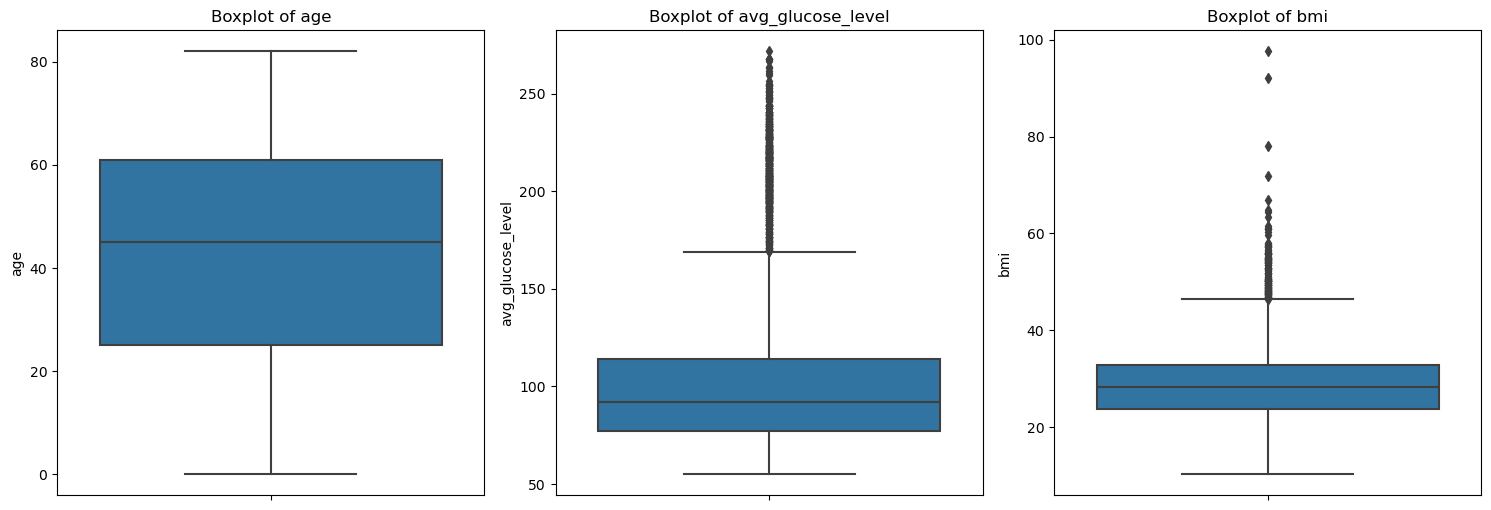

In [15]:
plt.figure(figsize=(20, 10))

for i, var in enumerate(new_df[numerical_datatypes].select_dtypes(float).columns):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=var, data=new_df)
    plt.title(f'Boxplot of {var}')

plt.tight_layout()
plt.show();


In [ ]:
# def find_outliers(data):
#     # Sort the data
#     sorted_data = sorted(data)
    
#     # Calculate first and third quartile
#     Q1 = np.percentile(sorted_data, 25)
#     Q3 = np.percentile(sorted_data, 75)
    
#     # Calculate interquartile range (IQR)
#     IQR = Q3 - Q1
    
#     # Find lower and upper bounds
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Identify outliers
#     outliers = []
#     for x in sorted_data:
#         if x < lower_bound or x > upper_bound:
#             outliers.append(x)
    
#     return outliers


In [16]:
def identify_outliers(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    outliers = np.abs(z_scores) > threshold
    return df[column_name][outliers]


In [17]:
bmi_outliers = identify_outliers(new_df, 'bmi')
avg_glucose_level_outliers = identify_outliers(new_df, 'avg_glucose_level')

In [18]:
bmi_outliers.count()

59

In [19]:
avg_glucose_level_outliers.count()

49

In [20]:
new_df_filtered = new_df[~new_df['bmi'].isin(bmi_outliers) & ~new_df['avg_glucose_level'].isin(avg_glucose_level_outliers)]


In [21]:
new_df_filtered.shape

(5002, 12)

Univariate Data Analysis

**Gender**

In [22]:
new_df_filtered['gender'].value_counts()

gender
Female    2925
Male      2076
Other        1
Name: count, dtype: int64

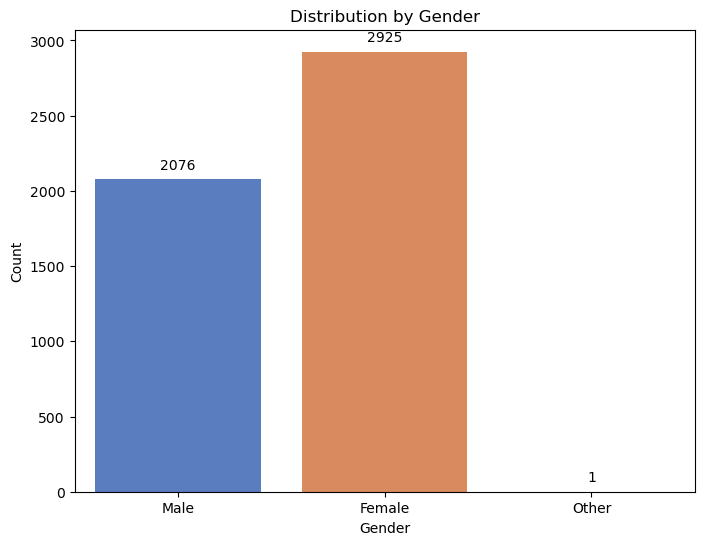

In [23]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x=new_df_filtered['gender'], data=new_df_filtered['gender'],palette='muted')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()
# plt.savefig("Images/Distribution by Gender.png")

In [24]:
new_df_filtered.drop(new_df_filtered[new_df_filtered['gender'] == 'Other'].index, inplace=True)

In [25]:
new_df_filtered.shape

(5001, 12)

**Age**

In [26]:
new_df_filtered['age'].dtype

dtype('float64')

In [27]:
new_df_filtered['age'] = new_df_filtered['age'].astype(int)

In [28]:
new_df_filtered['age'].dtype

dtype('int32')

In [29]:
new_df_filtered['age'].nunique()

83

In [30]:
age_counts = new_df_filtered['age'].value_counts().sort_index(ascending=True)

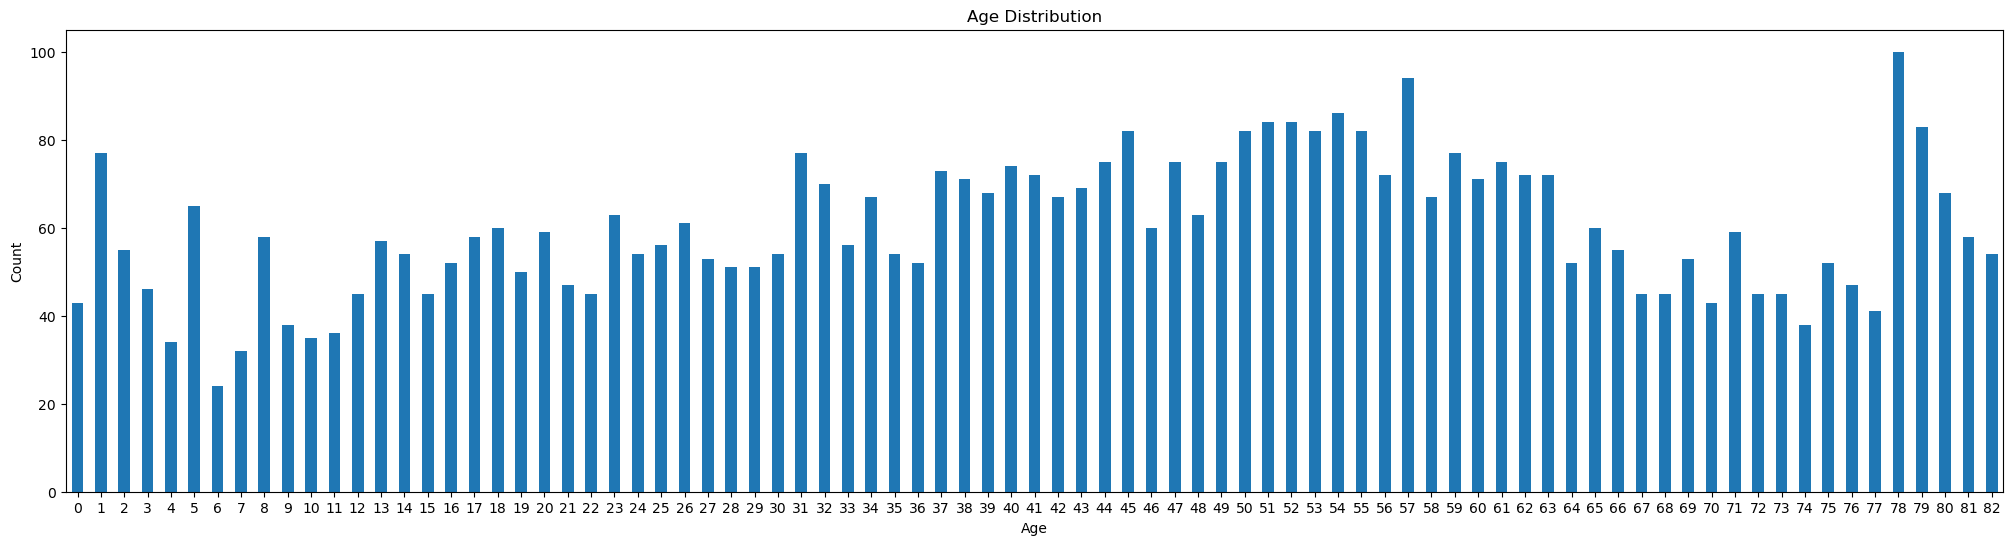

In [31]:
plt.figure(figsize=(25, 6))
age_counts.plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
# plt.show()
plt.savefig("Images/Age Distribution.png")

In [32]:
age_groups_count = new_df_filtered['age_group'].value_counts()
age_groups_count

age_group
Middle-Aged Adults    1857
Old-Aged Adults       1312
Young Adults           918
Children               413
Adolescents            326
Infants                175
Name: count, dtype: int64

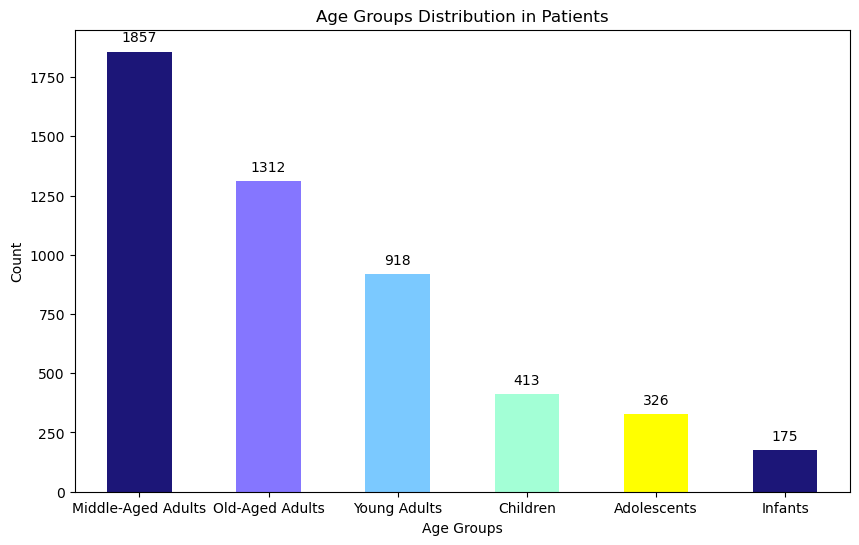

In [33]:
plt.figure(figsize=(10, 6))
ax = age_groups_count.plot(kind='bar', color = ["#1C1678","#8576FF","#7BC9FF","#A3FFD6","yellow"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Age Groups Distribution in Patients')
# plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Images/Age groups Distribution in Patients.png")

In [150]:
# # Define the age groups
# age_groups = {
#     "Child": [],
#     "Teenager": [],
#     "Young Adult": [],
#     "Adult": [],
#     "Senior": []
# }

# # Define a function to categorize an age
# def categorize_age(age):
#     if age < 13:
#         age_groups["Child"].append(age)
#     elif 13 <= age < 18:
#         age_groups["Teenager"].append(age)
#     elif 18 <= age < 35:
#         age_groups["Young Adult"].append(age)
#     elif 35 <= age < 60:
#         age_groups["Adult"].append(age)
#     else:
#         age_groups["Senior"].append(age)

# for age in new_df["age"]:
#     categorize_age(age)

**Hypertension**

In [34]:
new_df_filtered['hypertension'].dtype

dtype('int64')

In [35]:
new_df_filtered['hypertension'].nunique()

2

In [36]:
bp_counts = new_df_filtered['hypertension'].value_counts().sort_index(ascending=True)

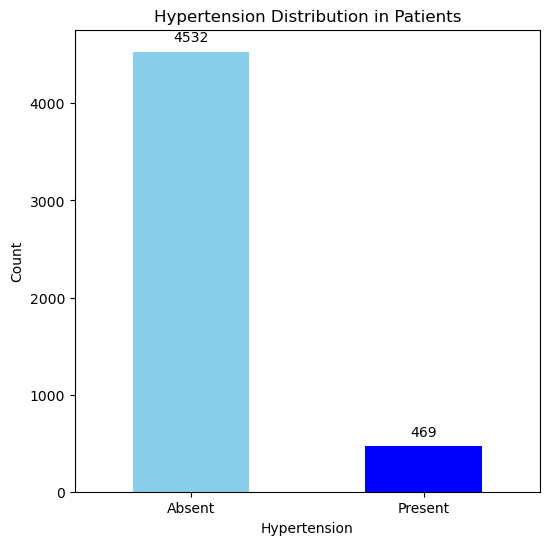

In [37]:
plt.figure(figsize=(6, 6))
ax = bp_counts.plot(kind='bar', color = ['skyblue','blue'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Hypertension Distribution in Patients')
plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Images/Hypertension Distribution in Patients.png")

In [38]:
stroke_bp = new_df_filtered['hypertension'].groupby(new_df_filtered['stroke']).value_counts()

In [39]:
stroke_bp_df = stroke_bp.reset_index()

In [40]:
stroke_bp_df

,stroke,hypertension,count
0,0,0,4353
1,0,1,409
2,1,0,179
3,1,1,60


In [41]:
stroke_bp_df['stroke'] = stroke_bp_df['stroke'].replace({0: 'No', 1: 'Yes'})

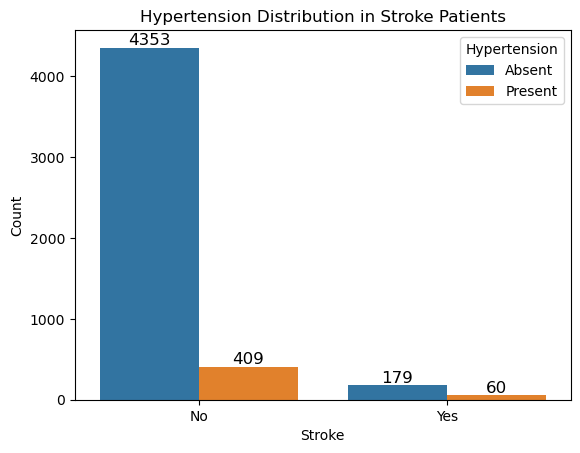

In [42]:
hue_labels = {0: 'Absent', 1: 'Present'}
stroke_bp_df['hypertension_label'] = stroke_bp_df['hypertension'].map(hue_labels)
sns.barplot(x='stroke', y='count', hue= 'hypertension_label', data=stroke_bp_df)
plt.legend(title='Hypertension', loc='upper right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title("Hypertension Distribution in Stroke Patients")
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show();
# plt.savefig("Hypertension Distribution by Patients' Gender.png");

**heart_disease**

In [43]:
heart_disease_counts = new_df_filtered['heart_disease'].value_counts()

In [44]:
heart_disease_counts

heart_disease
0    4735
1     266
Name: count, dtype: int64

In [45]:
stroke_heart_disease = new_df_filtered['heart_disease'].groupby(new_df_filtered['stroke']).value_counts()

In [46]:
stroke_heart_disease_df = stroke_heart_disease.reset_index()

In [47]:
stroke_heart_disease_df

,stroke,heart_disease,count
0,0,0,4539
1,0,1,223
2,1,0,196
3,1,1,43


In [48]:
stroke_heart_disease_df['stroke'] = stroke_heart_disease_df['stroke'].replace({0: 'No', 1: 'Yes'})

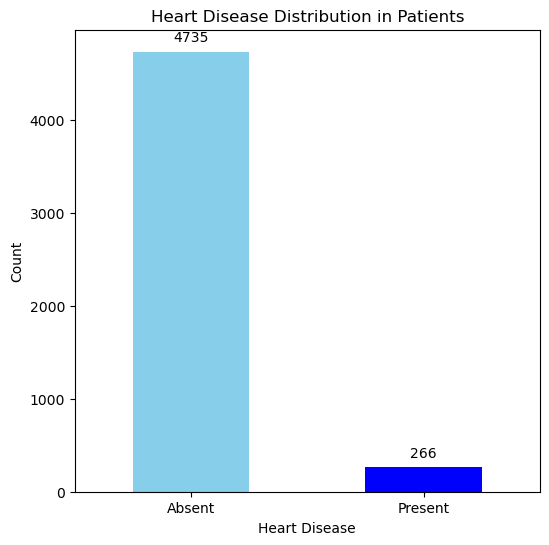

In [49]:
plt.figure(figsize=(6, 6))
ax = heart_disease_counts.plot(kind='bar', color = ['skyblue','blue'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Heart Disease Distribution in Patients')
plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Heart Disease Distribution in Patients.png")

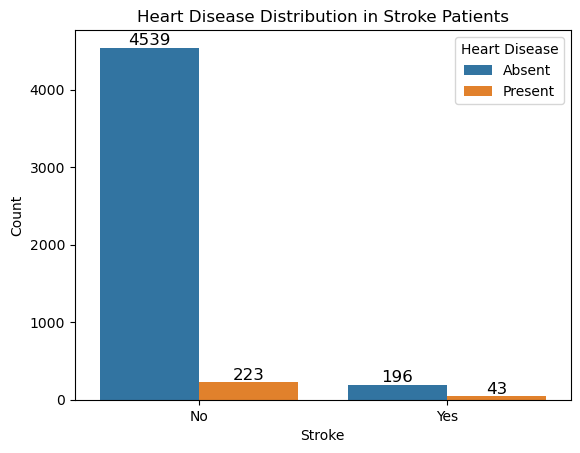

In [53]:
hue_labels = {0: 'Absent', 1: 'Present'}
stroke_heart_disease_df['heart_disease_label'] = stroke_heart_disease_df['heart_disease'].map(hue_labels)
sns.barplot(x='stroke', y='count', hue= 'heart_disease_label', data=stroke_heart_disease_df)
plt.legend(title='Heart Disease', loc='upper right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title("Heart Disease Distribution in Stroke Patients")
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show();
# plt.savefig("Heart Disease Distribution by Patients' Gender.png")

**ever_married**

In [50]:
new_df_filtered['ever_married'].dtype

dtype('O')

In [51]:
new_df_filtered['ever_married'].nunique()

2

In [52]:
ever_married_counts = new_df_filtered['ever_married'].value_counts()

In [53]:
ever_married_counts

ever_married
Yes    3260
No     1741
Name: count, dtype: int64

In [54]:
gender_marital = new_df_filtered['ever_married'].groupby(new_df_filtered['gender']).value_counts()

In [55]:
gender_marital_df = gender_marital.reset_index()

In [56]:
gender_marital_df

,gender,ever_married,count
0,Female,Yes,1943
1,Female,No,982
2,Male,Yes,1317
3,Male,No,759


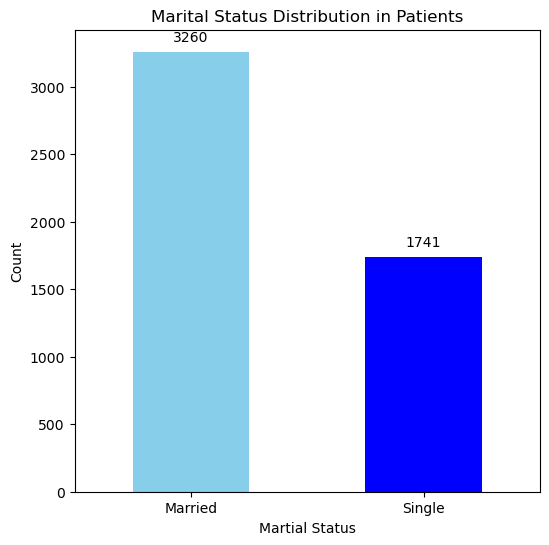

In [57]:
categories = ["Yes", "No"]
ticks = range(len(categories)) 
plt.figure(figsize=(6, 6))
ax = ever_married_counts.plot(kind='bar', color = ['skyblue','blue'] )
plt.xticks(ticks=ticks, labels=['Married', 'Single'], rotation=0)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Marital Status Distribution in Patients')
plt.xlabel('Martial Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Marital Status Distribution in Patients.png")

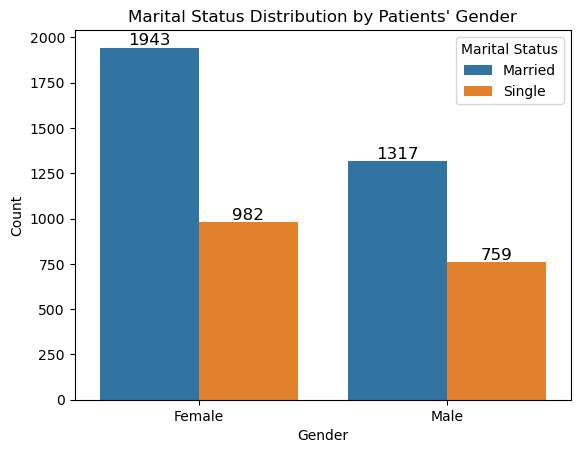

In [58]:
hue_labels = {"Yes": 'Married', "No": 'Single'}
gender_marital_df['marital_label'] = gender_marital_df['ever_married'].map(hue_labels)
sns.barplot(x='gender', y='count', hue= 'marital_label', data=gender_marital_df)
plt.legend(title='Marital Status', loc='upper right')
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                       textcoords='offset points')
plt.title("Marital Status Distribution by Patients' Gender")
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();
# plt.savefig("Marital Status Distribution by Patients' Gender.png")

**work_type**

In [59]:
new_df_filtered['work_type'].dtype

dtype('O')

In [60]:
new_df_filtered['work_type'].nunique()

5

In [61]:
new_df_filtered['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [62]:
work_type_counts = new_df_filtered['work_type'].value_counts()

In [63]:
work_type_counts

work_type
Private          2854
Self-employed     797
children          687
Govt_job          641
Never_worked       22
Name: count, dtype: int64

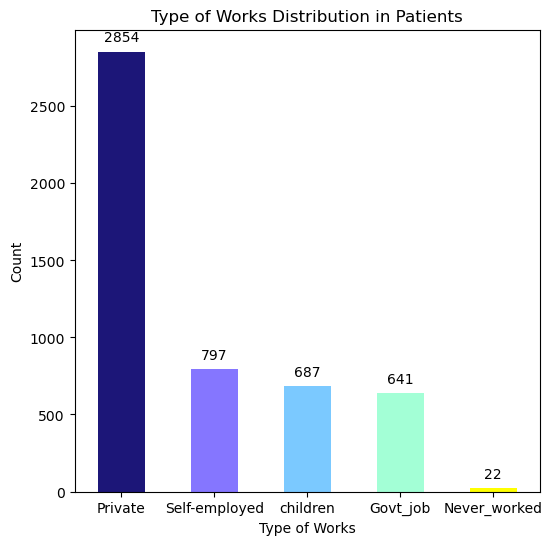

In [64]:
plt.figure(figsize=(6, 6))
ax = work_type_counts.plot(kind='bar', color = ["#1C1678","#8576FF","#7BC9FF","#A3FFD6","yellow"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Type of Works Distribution in Patients')
# plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Type of Works')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Type of Works Distribution in Patients.png")

**Residence_type**

In [65]:
new_df_filtered['Residence_type'].dtype

dtype('O')

In [66]:
new_df_filtered['Residence_type'].nunique()

2

In [67]:
new_df_filtered['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [68]:
residence_type_counts = new_df_filtered['Residence_type'].value_counts()

In [69]:
residence_type_counts

Residence_type
Urban    2542
Rural    2459
Name: count, dtype: int64

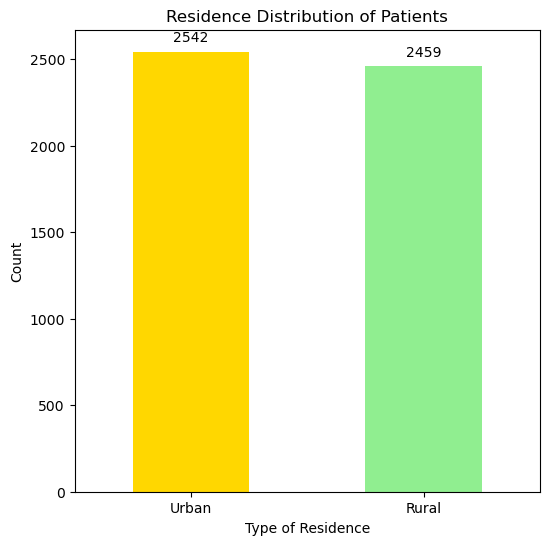

In [70]:
plt.figure(figsize=(6, 6))
ax = residence_type_counts.plot(kind='bar', color = ["gold","lightgreen"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Residence Distribution of Patients')
# plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Type of Residence')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Residence Distribution of Patients.png")

**avg_glucose_level**

In [71]:
new_df_filtered['avg_glucose_level'].dtype

dtype('float64')

In [72]:
new_df_filtered['avg_glucose_level'] = new_df_filtered['avg_glucose_level'].astype('int')

In [73]:
new_df_filtered['avg_glucose_level'].nunique()

186

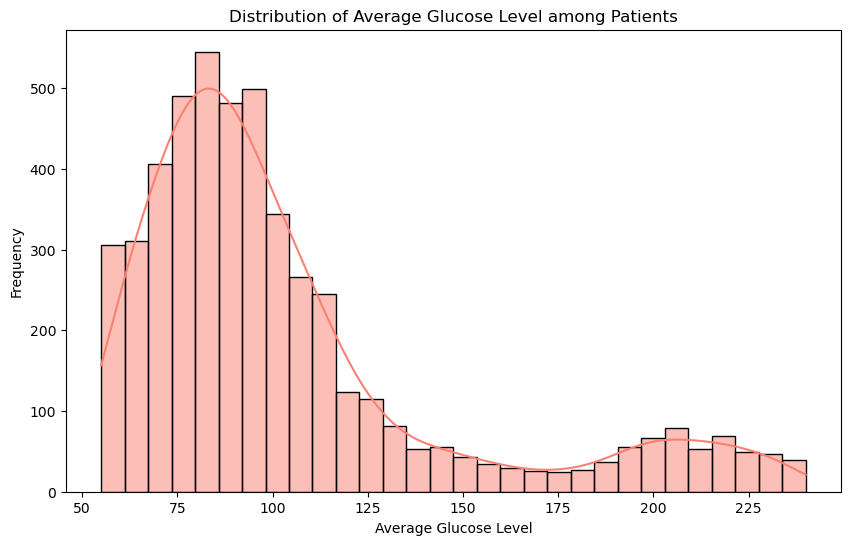

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(new_df_filtered['avg_glucose_level'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Average Glucose Level among Patients')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.show();
# plt.savefig("Distribution of Average Glucose Level among Patients.png")

Fasting Blood Glucose Levels <br><br>
Normal: 70-99 mg/dL (3.9-5.5 mmol/L) <br>
Prediabetes: 100-125 mg/dL (5.6-6.9 mmol/L) <br>
Diabetes: 126 mg/dL (7.0 mmol/L) or higher <br>

In [75]:
below_normal_glucose_level_counts = (new_df_filtered['avg_glucose_level'] < 70).sum()
normal_glucose_level_counts = ((new_df_filtered['avg_glucose_level'] >= 70) & (new_df_filtered['avg_glucose_level'] <= 99)).sum()
prediabetes_counts = ((new_df_filtered['avg_glucose_level'] >= 100) & (new_df_filtered['avg_glucose_level'] <= 125)).sum()
diabetes_counts = (new_df_filtered['avg_glucose_level'] >= 126).sum()

In [76]:
below_normal_glucose_level_counts

747

In [77]:
stroke_patients_df = new_df_filtered[new_df_filtered['stroke'] == 1]

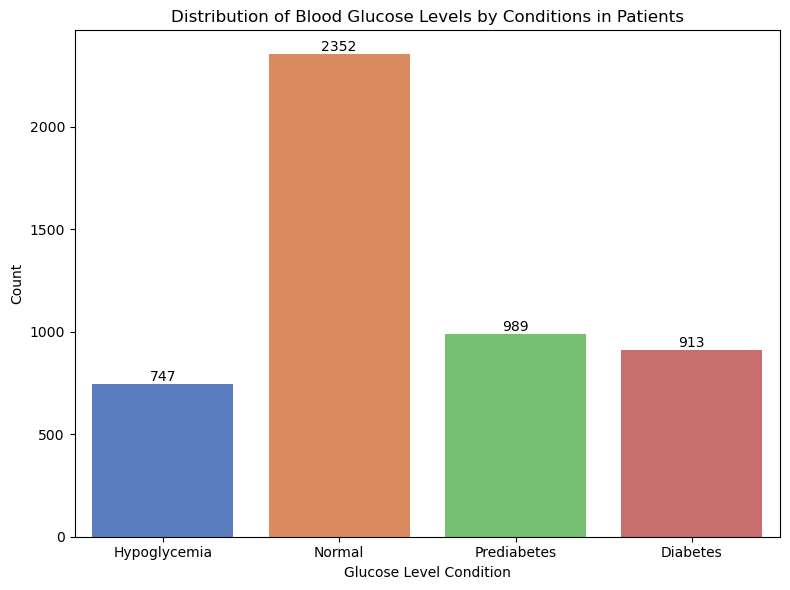

In [78]:
glucose_level_counts_df = pd.DataFrame({
    'Category': ['Hypoglycemia', 'Normal', 'Prediabetes', 'Diabetes'],
    'Count': [below_normal_glucose_level_counts, normal_glucose_level_counts, prediabetes_counts, diabetes_counts]
})


plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data = glucose_level_counts_df, palette='muted')


for index, row in glucose_level_counts_df.iterrows():
    plt.text(index, row['Count'], row['Count'], color='black', ha="center", va="bottom")


plt.title('Distribution of Blood Glucose Levels by Conditions in Patients')
plt.xlabel('Glucose Level Condition')
plt.ylabel('Count')

plt.tight_layout() 
plt.show()
# plt.savefig("Distribution of Blood Glucose Levels by Conditions in Patients.png");

In [79]:
below_normal_glucose_level_counts_stroke_patients = (stroke_patients_df['avg_glucose_level'] < 70).sum()
normal_glucose_level_counts_stroke_patients = ((stroke_patients_df['avg_glucose_level'] >= 70) & (stroke_patients_df['avg_glucose_level'] <= 99)).sum()
prediabetes_counts_stroke_patients = ((stroke_patients_df['avg_glucose_level'] >= 100) & (stroke_patients_df['avg_glucose_level'] <= 125)).sum()
diabetes_counts_stroke_patients = (stroke_patients_df['avg_glucose_level'] >= 126).sum()

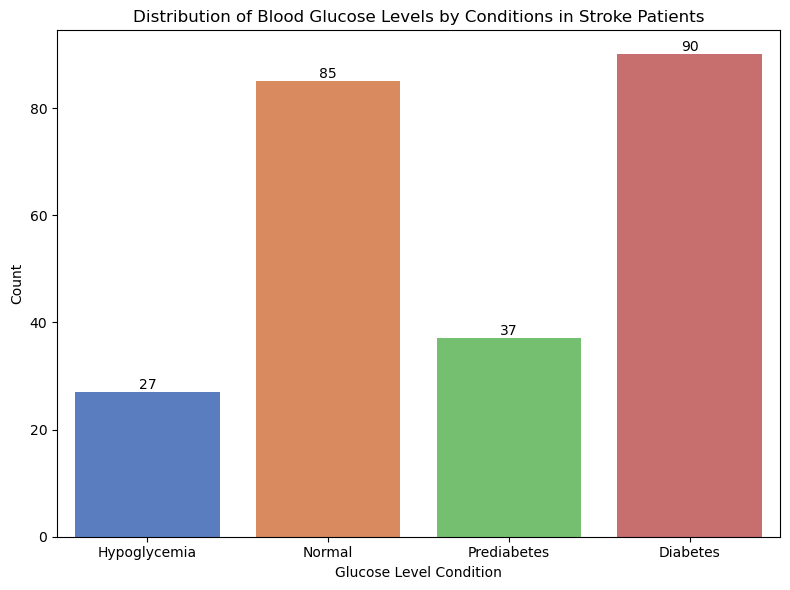

In [80]:
glucose_level_counts_df_stroke_patients = pd.DataFrame({
    'Category': ['Hypoglycemia', 'Normal', 'Prediabetes', 'Diabetes'],
    'Count': [below_normal_glucose_level_counts_stroke_patients, normal_glucose_level_counts_stroke_patients, prediabetes_counts_stroke_patients, diabetes_counts_stroke_patients]
})


plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data = glucose_level_counts_df_stroke_patients, palette='muted')


for index, row in glucose_level_counts_df_stroke_patients.iterrows():
    plt.text(index, row['Count'], row['Count'], color='black', ha="center", va="bottom")


plt.title('Distribution of Blood Glucose Levels by Conditions in Stroke Patients')
plt.xlabel('Glucose Level Condition')
plt.ylabel('Count')

plt.tight_layout() 
plt.show()


**bmi**

In [81]:
new_df_filtered['bmi'].dtype

dtype('float64')

In [82]:
new_df_filtered['bmi'].nunique()

375

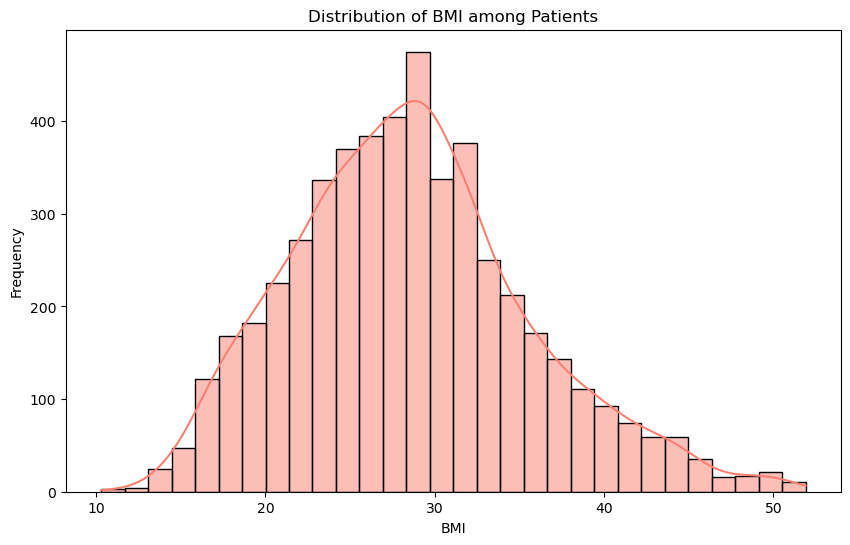

In [83]:
plt.figure(figsize=(10, 6))
sns.histplot(new_df_filtered['bmi'], bins=30, kde=True, color='salmon')
plt.title('Distribution of BMI among Patients')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show();
# plt.savefig("Distribution of BMI among Patients.png")

Body Mass Index (BMI)

- **Underweight:** less than **18.5** kg/m<sup>2</sup>
- **Normal weight:** **18.5 - 24.9** kg/m<sup>2</sup>
- **Overweight:** **25.0 - 29.9** kg/m<sup>2</sup>
- **Obesity:** **30.0 - 39.9** kg/m<sup>2</sup>
- **Morbid Obesity:** more than **40.0** kg/m<sup>2</sup>

In [84]:
underweight_counts = (new_df_filtered['bmi'] < 18.5).sum()
normal_weight_counts = ((new_df_filtered['bmi'] >= 18.5) & (new_df_filtered['bmi'] <= 24.9)).sum()
overweight_counts = ((new_df_filtered['bmi'] >= 25.0) & (new_df_filtered['bmi'] <= 29.9)).sum()
obesity_counts = ((new_df_filtered['bmi'] >= 30.0) & (new_df_filtered['bmi'] <= 39.9)).sum()
morbid_obesity_counts = (new_df_filtered['bmi'] >= 40.0).sum()

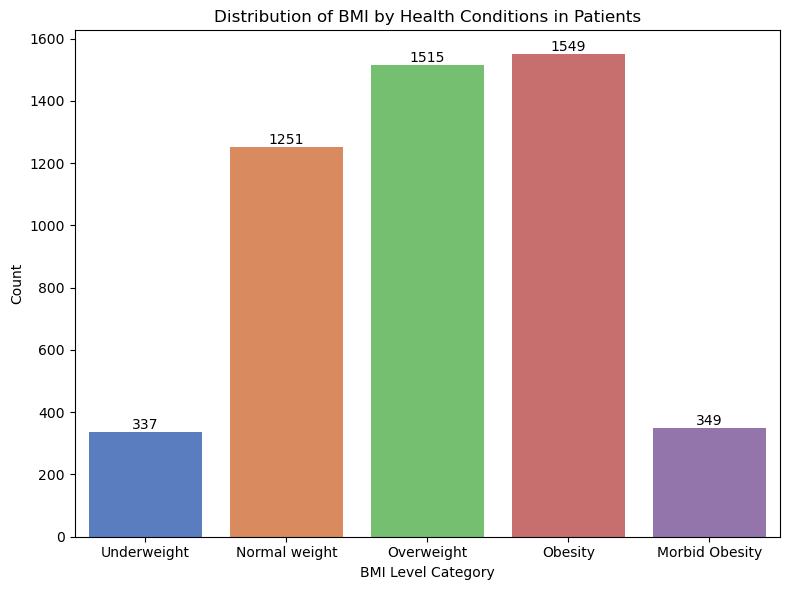

In [85]:
bmi_counts_df = pd.DataFrame({
    'Category': ['Underweight', 'Normal weight', 'Overweight', 'Obesity', 'Morbid Obesity'],
    'Count': [underweight_counts, normal_weight_counts, overweight_counts, obesity_counts,morbid_obesity_counts]
})


plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data = bmi_counts_df, palette='muted')


for index, row in bmi_counts_df.iterrows():
    plt.text(index, row['Count'], row['Count'], color='black', ha="center", va="bottom")


plt.title('Distribution of BMI by Health Conditions in Patients')
plt.xlabel('BMI Level Category')
plt.ylabel('Count')

plt.tight_layout() 
plt.show()
# plt.savefig("Distribution of BMI by Health Conditions in Patients.png");

In [86]:
underweight_counts_stroke_patients = (stroke_patients_df['bmi'] < 18.5).sum()
normal_weight_counts_stroke_patients = ((stroke_patients_df['bmi'] >= 18.5) & (stroke_patients_df['bmi'] <= 24.9)).sum()
overweight_counts_stroke_patients = ((stroke_patients_df['bmi'] >= 25.0) & (stroke_patients_df['bmi'] <= 29.9)).sum()
obesity_counts_stroke_patients = ((stroke_patients_df['bmi'] >= 30.0) & (stroke_patients_df['bmi'] <= 39.9)).sum()
morbid_obesity_counts_stroke_patients = (stroke_patients_df['bmi'] >= 40.0).sum()

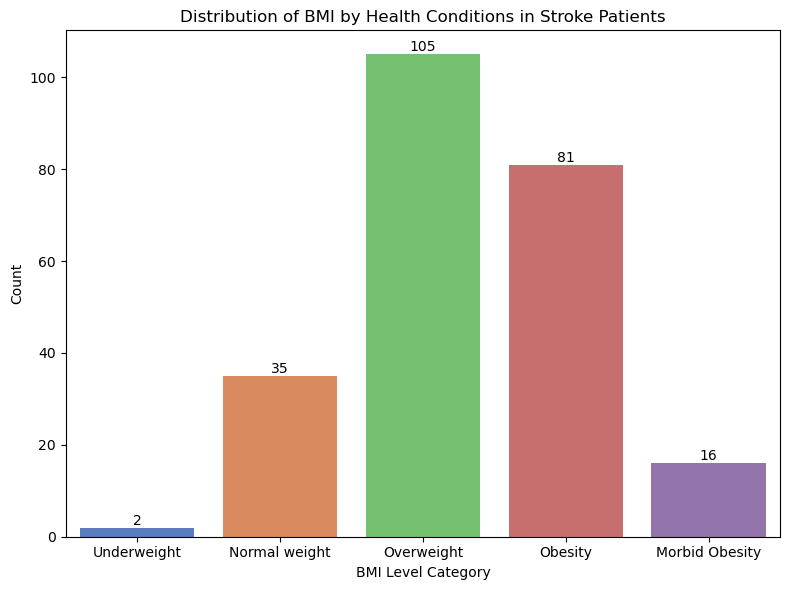

In [87]:
bmi_counts_df_stroke_patients = pd.DataFrame({
    'Category': ['Underweight', 'Normal weight', 'Overweight', 'Obesity', 'Morbid Obesity'],
    'Count': [underweight_counts_stroke_patients, normal_weight_counts_stroke_patients, overweight_counts_stroke_patients, obesity_counts_stroke_patients,morbid_obesity_counts_stroke_patients]
})


plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data = bmi_counts_df_stroke_patients, palette='muted')


for index, row in bmi_counts_df_stroke_patients.iterrows():
    plt.text(index, row['Count'], row['Count'], color='black', ha="center", va="bottom")


plt.title('Distribution of BMI by Health Conditions in Stroke Patients')
plt.xlabel('BMI Level Category')
plt.ylabel('Count')

plt.tight_layout() 
plt.show()

**smoking_status**

In [88]:
new_df_filtered['smoking_status'].dtype

dtype('O')

In [89]:
new_df_filtered['smoking_status'].nunique()

4

In [90]:
new_df_filtered['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [91]:
smoking_status_counts = new_df_filtered['smoking_status'].value_counts()

In [92]:
smoking_status_counts

smoking_status
never smoked       1849
Unknown            1524
formerly smoked     861
smokes              767
Name: count, dtype: int64

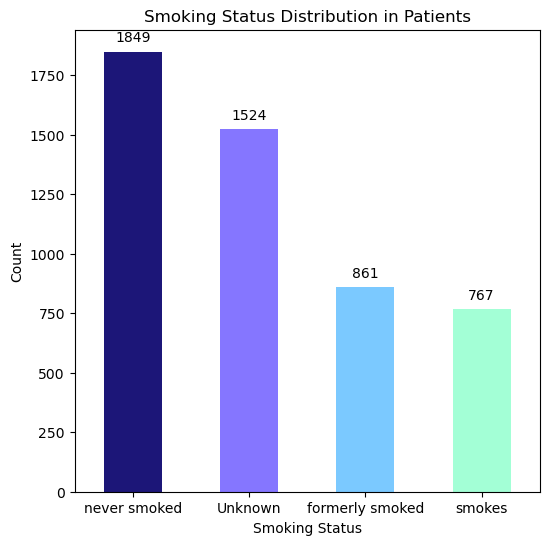

In [93]:
plt.figure(figsize=(6, 6))
ax = smoking_status_counts.plot(kind='bar', color = ["#1C1678","#8576FF","#7BC9FF","#A3FFD6"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Smoking Status Distribution in Patients')
# plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Smoking Status Distribution in Patients.png")

In [94]:
smoking_status_stroke_patients = stroke_patients_df['smoking_status'].value_counts()

In [111]:
# smoking_status_stroke_patients = smoking_status_stroke_patients.reset_index()

In [95]:
smoking_status_stroke_patients

smoking_status
never smoked       86
formerly smoked    67
Unknown            47
smokes             39
Name: count, dtype: int64

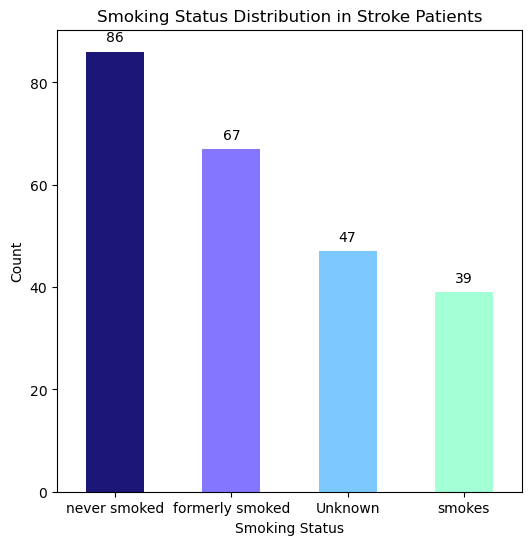

In [96]:
plt.figure(figsize=(6, 6))
ax = smoking_status_stroke_patients.plot(kind='bar', color = ["#1C1678","#8576FF","#7BC9FF","#A3FFD6"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Smoking Status Distribution in Stroke Patients')
# plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

**stroke**

In [97]:
new_df_filtered['stroke'].dtype

dtype('int64')

In [98]:
new_df_filtered['stroke'].unique()

array([1, 0], dtype=int64)

In [99]:
stroke_counts = new_df_filtered['stroke'].value_counts()

In [100]:
stroke_counts

stroke
0    4762
1     239
Name: count, dtype: int64

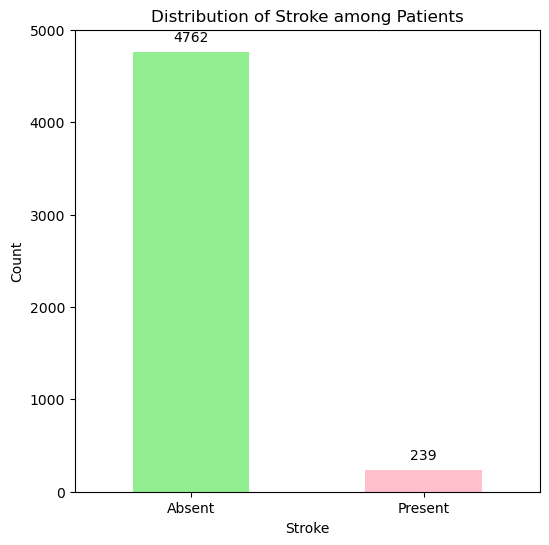

In [101]:
plt.figure(figsize=(6, 6))
ax = stroke_counts.plot(kind='bar', color = ["lightgreen","pink"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.title('Distribution of Stroke among Patients')
plt.xticks(ticks=[0, 1], labels=['Absent', 'Present'], rotation=0)
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
# plt.savefig("Distribution of Stroke among Patients.png")

In [214]:
# # # Define the age groups
# # age_groups = {
# #     "Child": [],
# #     "Teenager": [],
# #     "Young Adult": [],
# #     "Adult": [],
# #     "Senior": []
# # }

# # Define a function to categorize an age
# def categorize_age(age):
#     if age < 13:
#         return "Child (less than 13 y/o)"
#     elif 13 <= age < 18:
#         return "Teenager (Btw 13 to 18 y/o)"
#     elif 18 <= age < 35:
#         return "Young Adult (Btw 18 to 35 y/o)"
#     elif 35 <= age < 60:
#         return "Adult (Btw 35 to 60 y/o)"
#     else:
#         return "Senior (More than 60 y/o)"

# new_df["age_category"] = new_df["age"].apply(categorize_age)

In [102]:
new_df_filtered

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67,0,1,Yes,Private,Urban,228,36.6,formerly smoked,1,Old-Aged Adults
1,Female,61,0,0,Yes,Self-employed,Rural,202,29.7,never smoked,1,Old-Aged Adults
2,Male,80,0,1,Yes,Private,Rural,105,32.5,never smoked,1,Old-Aged Adults
3,Female,49,0,0,Yes,Private,Urban,171,34.4,smokes,1,Middle-Aged Adults
4,Female,79,1,0,Yes,Self-employed,Rural,174,24.0,never smoked,1,Old-Aged Adults
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80,1,0,Yes,Private,Urban,83,29.7,never smoked,0,Old-Aged Adults
5106,Female,81,0,0,Yes,Self-employed,Urban,125,40.0,never smoked,0,Old-Aged Adults
5107,Female,35,0,0,Yes,Self-employed,Rural,82,30.6,never smoked,0,Young Adults
5108,Male,51,0,0,Yes,Private,Rural,166,25.6,formerly smoked,0,Middle-Aged Adults


In [103]:
age_category_stroke_count = new_df_filtered["stroke"].groupby(new_df_filtered["age_group"]).sum()

In [104]:
age_category_stroke_count

age_group
Adolescents             1
Children                0
Infants                 1
Middle-Aged Adults     67
Old-Aged Adults       169
Young Adults            1
Name: stroke, dtype: int64

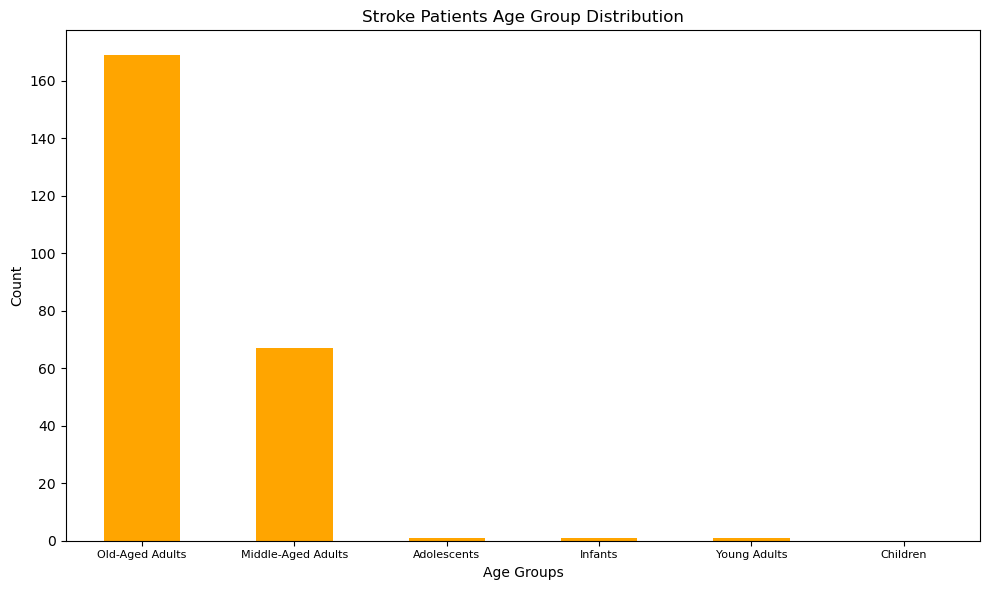

In [105]:
plt.figure(figsize=(10, 6))
age_category_stroke_count.sort_values(ascending= False).plot(kind='bar', color='orange')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Stroke Patients Age Group Distribution')
plt.xticks(rotation=0, ha='center', fontsize=8)
plt.tight_layout()
plt.show()
# plt.savefig("Stroke Patients Age Group Distribution.png")

General Statistics

In [106]:
new_df_filtered[numerical_datatypes].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,42.977205,0.093781,0.053189,104.037592,28.545651,0.047790
std,22.688047,0.291553,0.224433,42.886480,7.026510,0.213344
min,0.000000,0.000000,0.000000,55.000000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.000000,23.600000,0.000000
50%,44.000000,0.000000,0.000000,91.000000,28.200000,0.000000
75%,61.000000,0.000000,0.000000,112.000000,32.500000,0.000000
max,82.000000,1.000000,1.000000,240.000000,51.900000,1.000000


In [107]:
#age normality and spread

print("Skewness of age",new_df_filtered['age'].skew())
print("Kurtosis of age",new_df_filtered['age'].kurtosis())

Skewness of age -0.12844678967622
Kurtosis of age -0.9951024483211026


In [108]:
#avg_glucose_level normality and spread

print("Skewness of average glucose level",new_df_filtered['avg_glucose_level'].skew())
print("Kurtosis of average glucose level",new_df_filtered['avg_glucose_level'].kurtosis())

Skewness of average glucose level 1.5662037449741337
Kurtosis of average glucose level 1.7019154575693305


In [109]:
#bmi normality and spread

print("Skewness of bmi",new_df_filtered['bmi'].skew())
print("Kurtosis of bmi",new_df_filtered['bmi'].kurtosis())

Skewness of bmi 0.4488590828061175
Kurtosis of bmi 0.11649710452225737


Feature Scaling

In [112]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit and transform the columns to be normalized
standardized_values = scaler.fit_transform(new_df_filtered[['avg_glucose_level', 'bmi']])

# Create a DataFrame with the normalized values
standardized_df = pd.DataFrame(standardized_values, columns=['avg_glucose_level', 'bmi'])

# Update the original DataFrame with the normalized values
new_df_filtered[['avg_glucose_level', 'bmi']] = standardized_df[['avg_glucose_level', 'bmi']]

In [113]:
new_df_filtered

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,67,0,1,Yes,Private,Urban,2.890767,1.146395,formerly smoked,1,Old-Aged Adults
1,Female,61,0,0,Yes,Self-employed,Rural,2.284454,0.164301,never smoked,1,Old-Aged Adults
2,Male,80,0,1,Yes,Private,Rural,0.022443,0.562832,never smoked,1,Old-Aged Adults
3,Female,49,0,0,Yes,Private,Urban,1.561543,0.833264,smokes,1,Middle-Aged Adults
4,Female,79,1,0,Yes,Self-employed,Rural,1.631503,-0.646993,never smoked,1,Old-Aged Adults
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80,1,0,Yes,Private,Urban,NaN,NaN,never smoked,0,Old-Aged Adults
5106,Female,81,0,0,Yes,Self-employed,Urban,NaN,NaN,never smoked,0,Old-Aged Adults
5107,Female,35,0,0,Yes,Self-employed,Rural,NaN,NaN,never smoked,0,Young Adults
5108,Male,51,0,0,Yes,Private,Rural,NaN,NaN,formerly smoked,0,Middle-Aged Adults


Feature Encoding

In [114]:
encoded_new_df = pd.get_dummies(new_df_filtered, columns=['gender', 'ever_married','work_type','Residence_type','smoking_status'], drop_first=True)

In [115]:
encoded_new_df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_group,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,2.890767,1.146395,1,Old-Aged Adults,True,True,False,True,False,False,True,True,False,False
1,61,0,0,2.284454,0.164301,1,Old-Aged Adults,False,True,False,False,True,False,False,False,True,False
2,80,0,1,0.022443,0.562832,1,Old-Aged Adults,True,True,False,True,False,False,False,False,True,False
3,49,0,0,1.561543,0.833264,1,Middle-Aged Adults,False,True,False,True,False,False,True,False,False,True
4,79,1,0,1.631503,-0.646993,1,Old-Aged Adults,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80,1,0,NaN,NaN,0,Old-Aged Adults,False,True,False,True,False,False,True,False,True,False
5106,81,0,0,NaN,NaN,0,Old-Aged Adults,False,True,False,False,True,False,True,False,True,False
5107,35,0,0,NaN,NaN,0,Young Adults,False,True,False,False,True,False,False,False,True,False
5108,51,0,0,NaN,NaN,0,Middle-Aged Adults,True,True,False,True,False,False,False,True,False,False
